Convolutional Neural Network (CNN) — Classifying Handwritten Digits

Dataset: MNIST Dataset (torchvision.datasets.MNIST)

Objective: Build and train a Convolutional Neural Network (CNN) to classify
handwritten digits (0-9) from the MNIST dataset.

1. Load & Preprocess the Data

* Load the MNIST dataset.
* Normalize the images so that the pixel values are between 0 and 1 (important for
neural networks).




In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Let us load and pre process the data
# Normalizing the data so that it is between 0 and 1
transform = transforms.ToTensor()

# Download and load training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

2. Visualize the Data
* Pick any one digit (0–9) and display a few example images of that digit from the
MNIST dataset.
* Optional: Display a few examples of other digits.

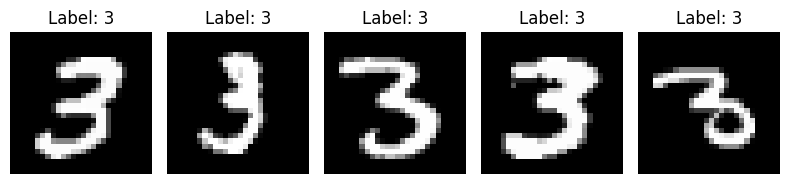

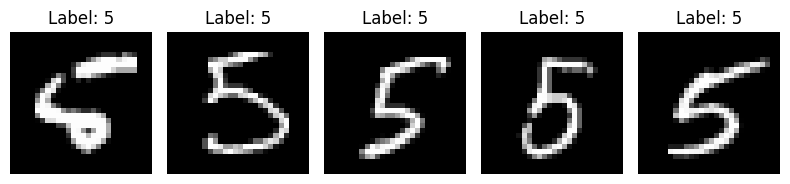

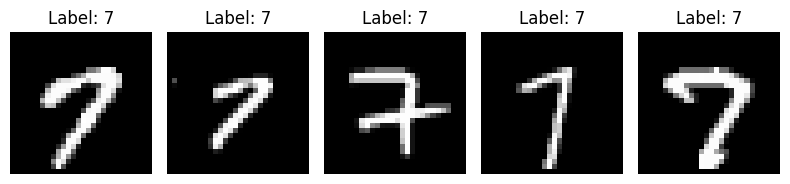

In [5]:
def show_digit_examples(digit, dataset):
    plt.figure(figsize=(8, 4))
    count = 0
    for img, label in dataset:
        if label == digit:
            plt.subplot(1, 5, count + 1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(f'Label: {label}')
            plt.axis('off')
            count += 1
            if count == 5:
                break
    plt.tight_layout()
    plt.show()

# Example: show digit "3"
show_digit_examples(3, train_dataset)
show_digit_examples(5, test_dataset)
show_digit_examples(7, train_dataset)

3. Build the CNN
* Implement a CNN with at least two convolutional layers, ReLU activation, and
max pooling layers.
* Experiment with the architecture (e.g., number of layers, filter sizes) and
hyperparameters (e.g., learning rate, batch size) to improve performance.
* Use Cross Entropy Loss as the loss function and Adam as the optimizer.

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layer 1: 1 input channel (grayscale), 32 filters, kernel size 3
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        # Convolutional layer 2: 32 → 64 filters
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # image shrinks after 2 poolings
        self.fc2 = nn.Linear(128, 10)          # 10 output classes (digits)

    def forward(self, x):
        x = F.relu(self.conv1(x))        # Conv + ReLU
        x = F.max_pool2d(x, 2, 2)        # Max pooling 2x2
        x = F.relu(self.conv2(x))        # Conv + ReLU
        x = F.max_pool2d(x, 2, 2)        # Max pooling again
        x = x.view(-1, 64 * 7 * 7)       # Flatten the tensor
        x = F.relu(self.fc1(x))          # Dense layer + ReLU
        x = self.fc2(x)                  # Output layer
        return x
# Now let us Initialize model, loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trackers for plotting later
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


4. Train the Model
* Train the model for 10 epochs.
* After each epoch, calculate and print:
* Training and test loss.
* Training and test accuracy.

In [7]:
# Step 6: Train the model
for epoch in range(1, 11):  # 10 epochs
    model.train()
    correct = 0
    total = 0
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_loss = running_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = correct / total
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Test Loss={test_losses[-1]:.4f}, "
          f"Train Acc={train_accuracy:.4f}, Test Acc={test_accuracy:.4f}")


Epoch 1: Train Loss=0.1750, Test Loss=0.0457, Train Acc=0.9468, Test Acc=0.9839
Epoch 2: Train Loss=0.0503, Test Loss=0.0378, Train Acc=0.9845, Test Acc=0.9874
Epoch 3: Train Loss=0.0351, Test Loss=0.0328, Train Acc=0.9892, Test Acc=0.9889
Epoch 4: Train Loss=0.0253, Test Loss=0.0320, Train Acc=0.9918, Test Acc=0.9909
Epoch 5: Train Loss=0.0197, Test Loss=0.0282, Train Acc=0.9938, Test Acc=0.9909
Epoch 6: Train Loss=0.0148, Test Loss=0.0344, Train Acc=0.9951, Test Acc=0.9904
Epoch 7: Train Loss=0.0123, Test Loss=0.0357, Train Acc=0.9957, Test Acc=0.9886
Epoch 8: Train Loss=0.0101, Test Loss=0.0357, Train Acc=0.9968, Test Acc=0.9895
Epoch 9: Train Loss=0.0076, Test Loss=0.0287, Train Acc=0.9974, Test Acc=0.9918
Epoch 10: Train Loss=0.0082, Test Loss=0.0442, Train Acc=0.9970, Test Acc=0.9886



5. Create the Following Plots
* Plot 1: Training and test loss vs. epochs
* Plot 2: Training and test accuracy vs. epochs
* Plot 3: Final confusion matrix (visualized as a heatmap with class labels)

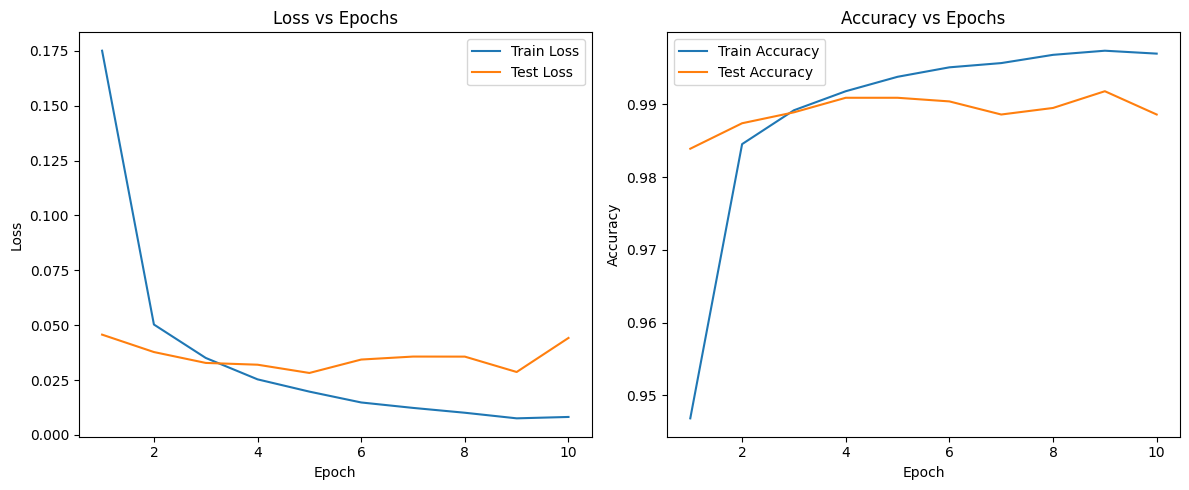

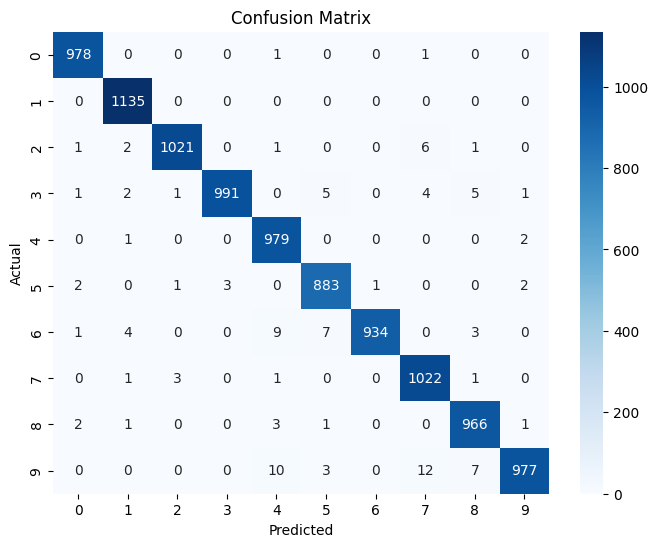

In [9]:
# Step 7: Plot training/test loss and accuracy
epochs_range = range(1, 11)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.tight_layout()
plt.show()

# Step 8: Confusion matrix on test data
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
